## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

In [2]:
# install yellowbrick to visualize ROC curve of a multiclass problem
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the necessary libraries

In [3]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from textblob import TextBlob
import nltk
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from pprint import pprint

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from yellowbrick.classifier import ROCAUC

In [4]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [5]:
# Opening JSON file 
f = open("/content/drive/MyDrive/complaints-2021-05-14_08_16.json")
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
#learn the stats of numeric data column score
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [9]:
#print the column names
pprint(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [10]:
#Inspect the number of missing values percentage
round(df.isna().sum()*100/78313,2)

_index                                0.00
_type                                 0.00
_id                                   0.00
_score                                0.00
_source.tags                         86.08
_source.zip_code                      8.63
_source.complaint_id                  0.00
_source.issue                         0.00
_source.date_received                 0.00
_source.state                         2.54
_source.consumer_disputed             0.00
_source.product                       0.00
_source.company_response              0.00
_source.company                       0.00
_source.submitted_via                 0.00
_source.date_sent_to_company          0.00
_source.company_public_response      99.99
_source.sub_product                  13.50
_source.timely                        0.00
_source.complaint_what_happened       0.00
_source.sub_issue                    59.12
_source.consumer_consent_provided     1.29
dtype: float64

In [11]:
#Assign new column names
#Removing "_" from column names
df.columns=[re.sub('^_','',col) for col in df.columns]

#Removing "source." from column names
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]

list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [12]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)
df.shape

(78313, 22)

In [13]:
#Check the number of missing values percentage
round(df.isna().sum()*100/78313,2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened      73.09
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

####  ~73% of the values in Complaint_what_happen are blank

In [14]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def cleanup_text(text):
  #Make the text lowercase
  text=text.lower()    
  #Remove text in square brackets
  text=re.sub(r'\[.*?\]','',text)
  #Remove punctuation
  text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)
  #Remove words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)
  return text

In [16]:
# Convert complaint_what_happened column to string for performing text operations
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(cleanup_text))

In [17]:
df_clean

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...
10,"chase card was reported on xx/xx/. however, fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...
...,...
78303,after being a chase card customer for well ove...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx..."
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs. i've had ...


In [18]:
#Write your function to Lemmatize the texts
def lemmmatize_text(text):
    lem_list = []
    doc = nlp(text)
    for token in doc:
        lem_list.append(token.lemma_)
    return " ".join(lem_list)

In [19]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmmatize_text)

In [20]:
df_clean

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my..."
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...


In [21]:
#Write your function to extract the POS tags 

def pos_tag(text):
    sent = []
    blob = TextBlob(text)
    sent = [word for (word,tag) in blob.tags if tag=='NN']
    return " ".join(sent)

df_clean["complaint_POS_removed"] =  df_clean['complaint_lemmatized'].apply(pos_tag) 

In [22]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",wednesday chas visa credit card provider claim...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




<Figure size 720x360 with 0 Axes>

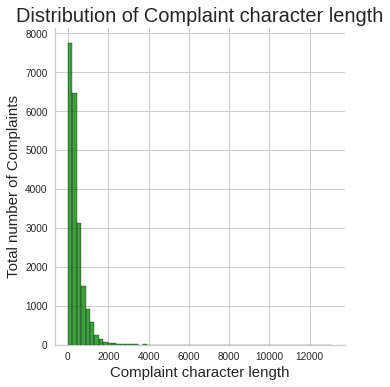

In [23]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]
char_len[:15]

plt.figure(figsize=[10,5])
sns.displot(char_len, kind='hist', bins=60, color='green')
plt.title("Distribution of Complaint character length",fontsize=20)
plt.xlabel("Complaint character length",size=15)
plt.ylabel("Total number of Complaints",size=15)

plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

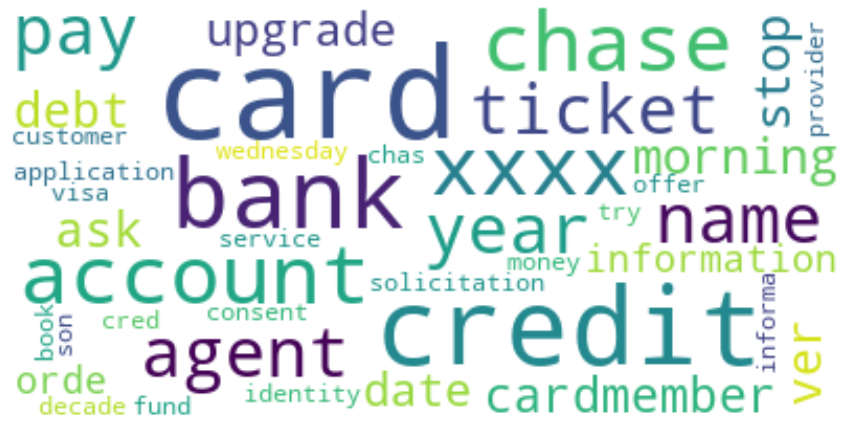

In [24]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(max_font_size=60, max_words=40, background_color="white", random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[15,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [25]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...,morning name stop bank cardmember ask debt ver...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",wednesday chas visa credit card provider claim...,wednesday chas visa credit card provider claim...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom xxxx prob...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
# Creating a function to extract top ngrams(unigram/bigram/trigram) based on the function inputs
def retrieve_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [27]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = retrieve_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])


In [28]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,chase,49099
1,account,47897
2,xxxx,43172
3,credit,34283
4,card,29632
5,bank,28508
6,payment,21336
7,time,16289
8,charge,15151
9,day,13065


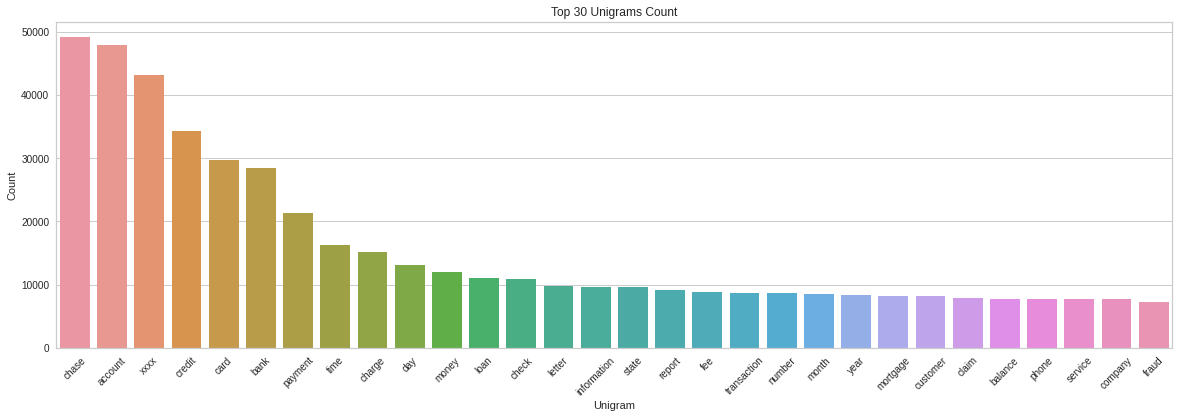

In [29]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Top 30 Unigrams Count")
plt.show()

In [30]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = retrieve_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])

In [31]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12879
1,xxxx xxxx,6198
2,credit report,4002
3,customer service,3080
4,chase credit,3058
5,chase bank,2898
6,bank account,2807
7,chase account,2769
8,account chase,2751
9,account account,2335


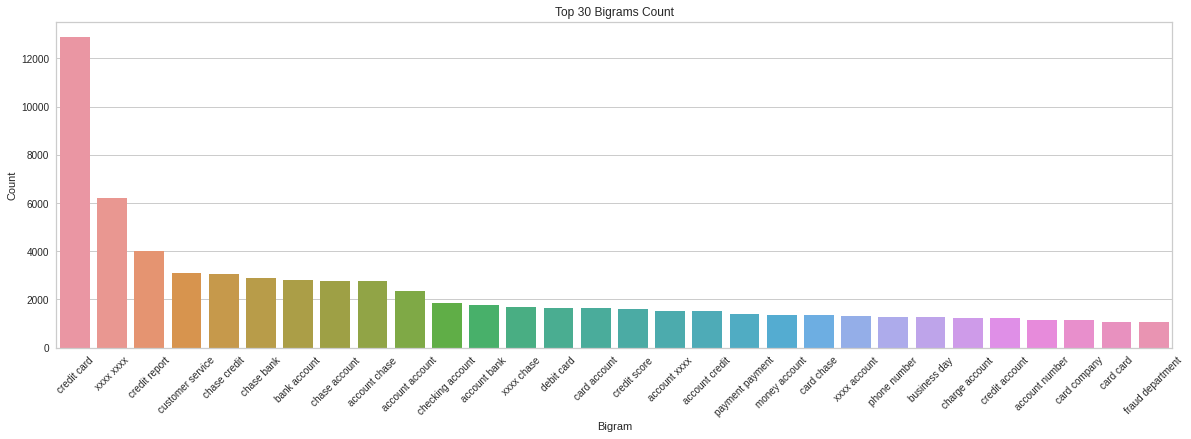

In [32]:
# Plotting top 30 Bigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Top 30 Bigrams Count")
plt.show()

In [33]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = retrieve_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])


In [34]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,2135
1,xxxx xxxx xxxx,1060
2,credit card account,1057
3,credit card company,994
4,credit card chase,672
5,credit card credit,509
6,inquiry credit report,482
7,charge credit card,431
8,account credit card,418
9,card credit card,382


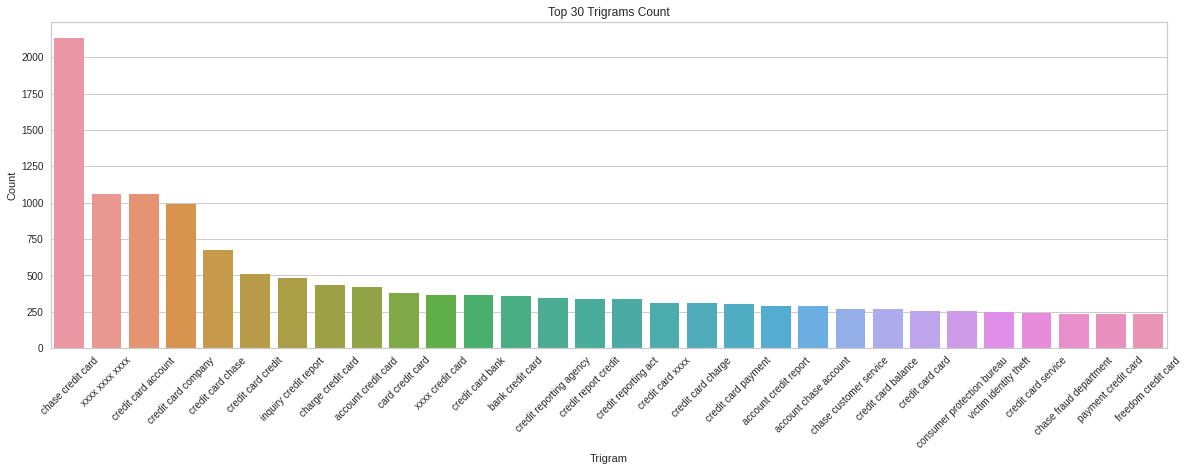

In [35]:
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Top 30 Trigrams Count")
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [36]:
df_clean.shape

(21072, 4)

In [37]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [38]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...,morning name stop bank cardmember ask debt ver...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",wednesday chas visa credit card provider claim...,wednesday chas visa credit card provider claim...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [39]:
#Write your code here to initialise the TfidfVectorizer 
tfidf_vec = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [40]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
docterm_matrix = tfidf_vec.fit_transform(df_clean['Complaint_clean'])

In [41]:
docterm_matrix

<21072x7061 sparse matrix of type '<class 'numpy.float64'>'
	with 656292 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [42]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [43]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [44]:
nmf_model.fit(docterm_matrix)
len(tfidf_vec.get_feature_names_out())

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



7061

In [45]:
# Topic-term matrix
H = nmf_model.components_  

In [46]:
#Print the Top15 words for each of the topics
words = np.array(tfidf_vec.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,fund,chase,deposit,branch,day,checking,number,business,transaction,claim,transfer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,balance,year
Topic 3,payment,balance,month,fee,statement,auto,day,time,pay,date,account,credit,chase,year,mortgage
Topic 4,charge,card,chase,fee,dispute,transaction,merchant,fraud,purchase,claim,service,time,statement,refund,company
Topic 5,loan,mortgage,home,chase,modification,property,year,letter,rate,time,document,foreclosure,house,bank,sale


In [47]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(docterm_matrix)
topic_results.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2])

In [48]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [49]:
df_clean.shape

(21072, 5)

In [50]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...,morning name stop bank cardmember ask debt ver...,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [51]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,j.p restrict account debit card tuesday branch...,j.p restrict account debit card tuesday branch...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xx...,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
35,i opened the saving account for the {$.} bonus...,I open the saving account for the { $ . } bonu...,account bonus bonus auto transfer check transf...,account bonus bonus auto transfer check transf...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [52]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Theft/Dispute reporting", 3:"Mortgages/loans", 4:"Others" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [53]:
df_clean.shape

(21072, 5)

In [54]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...,morning name stop bank cardmember ask debt ver...,Others
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card / Prepaid card
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,Credit card / Prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card / Prepaid card
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card / Prepaid card
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",wednesday chas visa credit card provider claim...,wednesday chas visa credit card provider claim...,Mortgages/loans
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Mortgages/loans
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,Theft/Dispute reporting


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [55]:
#Create the dictionary again of Topic names and Topics
Topic_names = { "Bank account services":0, "Credit card / Prepaid card":1, "Theft/Dispute reporting":2,
               "Mortgages/loans":3, "Others":4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [56]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...,morning name stop bank cardmember ask debt ver...,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",wednesday chas visa credit card provider claim...,wednesday chas visa credit card provider claim...,3
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,2


In [57]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_what_happened', 'Topic']]

In [58]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,1
10,"chase card was reported on xx/xx/. however, fr...",1
11,"on xx/xx/, while trying to book a xxxx xxxx ...",1
14,my grand son give me check for {$.} i deposit ...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...",3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs. i've had ...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [59]:
#Write your code to get the Vector count
vect_count = CountVectorizer()
X_train_cnt = vect_count.fit_transform(training_data['complaint_what_happened'])

# Save word vector
pickle.dump(vect_count.vocabulary_, open("count_vector.pk1", "wb"))

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# Save tfidf
pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

**Model 1. Logistic Regression**

In [60]:
# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [61]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [62]:
# define the multinomial logistic regression model
logisticreg = LogisticRegression(random_state=42, multi_class='ovr', solver='liblinear').fit(X_train, y_train)

In [63]:
# Getting the score of the base model
logisticreg.score(X_test, y_test)

0.9206529992406985

* With the base Logistic Regression model, we got an accuracy of 92.06%

*  **HyperParameter Tuning**

In [64]:
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

In [65]:
# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
logreg_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [66]:
# Check best parameters
logreg_hpt.best_params_

{'C': 4, 'solver': 'liblinear'}

In [67]:
# Evaluating the tuned model
logreg_hpt.score(X_test, y_test)

0.9240698557327259

* With the tuned Logistic Regression model, we got an accuracy of 92.40% 

In [68]:
# Save Logistic Regression Model
pickle.dump(logreg_hpt, open("logreg_model.pk1", "wb"))

* **Model Evaluation**

In [69]:
# Load pickled model
logreg_model = pickle.load(open("logreg_model.pk1", "rb"))

In [70]:
# Make predictions on test data
y_pred = logreg_model.predict(X_test)

In [71]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1246   19    6   28   14]
 [  16 1194    6   45   10]
 [  10   19  503   15   16]
 [  53   42    7 1077   24]
 [  28   23    8   11  848]]


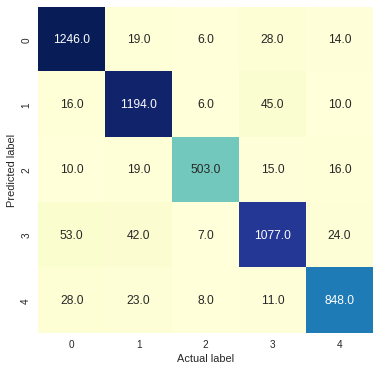

In [72]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="YlGnBu", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()


In [73]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Theft/Dispute reporting", "Mortgages/loans", "Others"]

In [74]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.92      0.95      0.93      1313
Credit card / Prepaid card       0.92      0.94      0.93      1271
   Theft/Dispute reporting       0.95      0.89      0.92       563
           Mortgages/loans       0.92      0.90      0.91      1203
                    Others       0.93      0.92      0.93       918

                  accuracy                           0.92      5268
                 macro avg       0.93      0.92      0.92      5268
              weighted avg       0.92      0.92      0.92      5268



* The overall accuracy of the Logistic Regression model is 92%.
* Precision and Recall are 92% and 92% respectively which makes this is a very good model.


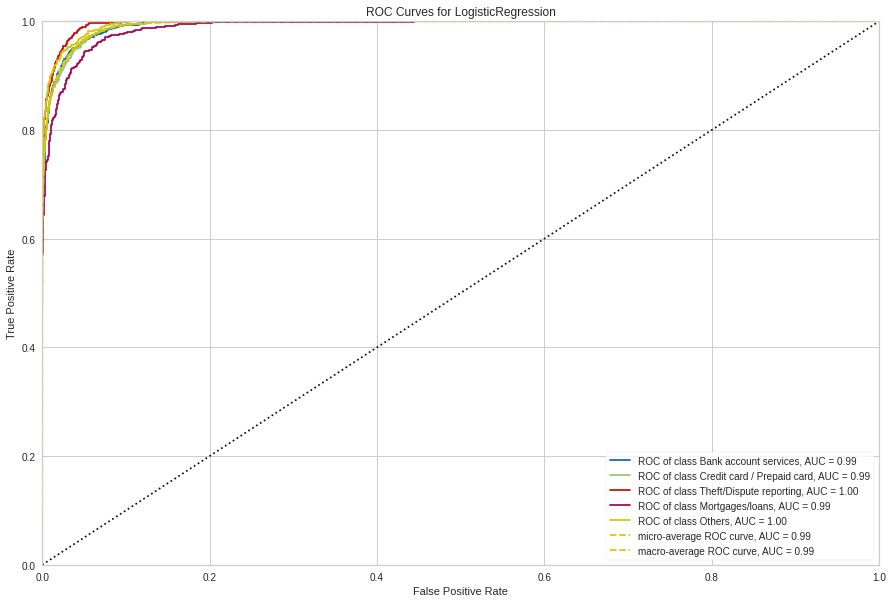

In [75]:
#visualizing the ROCAUC curve and the score for all the 5 class labels

fig = plt.figure(figsize=(15,10))

visualizer = ROCAUC(logisticreg, encoder={0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Theft/Dispute reporting", 3:"Mortgages/loans", 4:"Others"})

visualizer.fit(X_train,y_train)
visualizer.score(X_test, y_test) 
visualizer.show()

* **Model 2. Decision Tree Classifier**

In [76]:
# Importing DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier

In [77]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [78]:
# Initialize a Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [79]:
# Getting the score of the base model
dt.score(X_test, y_test)

0.7779043280182233

* With the base Decision Tree model, we got an accuracy of 77.79%

* **HyperParameter Tuning**

In [80]:
dt_grid = {"max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [81]:
# Setup grid hyperparameter search for Decision Tree
dt_hpt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=dt_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
dt_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


In [82]:
# Check decision tree best parameters
dt_hpt.best_params_

{'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 2}

In [83]:
# Evaluating the tuned decision tree model
dt_hpt.score(X_test, y_test)

0.7722095671981777

* With the tuned Decision Tree model, we got an accuracy of 77.22% which is less than the base model's accuracy of 77.22%

In [84]:
# Save Logistic Regression Model
pickle.dump(dt_hpt, open("dt_model.pk1", "wb"))

* **Model Evaluation**

In [85]:
# Load pickled model
dt_model = pickle.load(open("dt_model.pk1", "rb"))

In [86]:
# Make predictions on test data
y_pred = dt_model.predict(X_test)

In [87]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1050   61   29   67  106]
 [  38 1044   30   89   70]
 [  43   34  425   27   34]
 [ 148  116   22  771  146]
 [  47   28   39   26  778]]


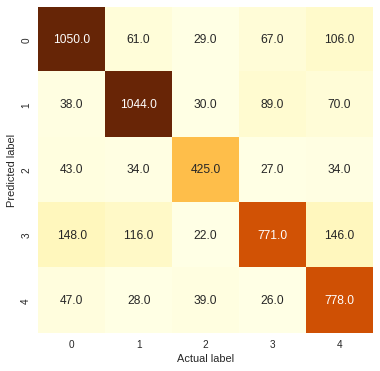

In [88]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="YlOrBr", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [89]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Theft/Dispute reporting", "Mortgages/loans", "Others"]

In [90]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.79      0.80      0.80      1313
Credit card / Prepaid card       0.81      0.82      0.82      1271
   Theft/Dispute reporting       0.78      0.75      0.77       563
           Mortgages/loans       0.79      0.64      0.71      1203
                    Others       0.69      0.85      0.76       918

                  accuracy                           0.77      5268
                 macro avg       0.77      0.77      0.77      5268
              weighted avg       0.78      0.77      0.77      5268



* The overall accuracy of the Decision Tree model is 77%
* Precision and Recall are 78% and 77% respectively
* This is an okay model but much poor compared to Logistic Regression accuracy was 92%

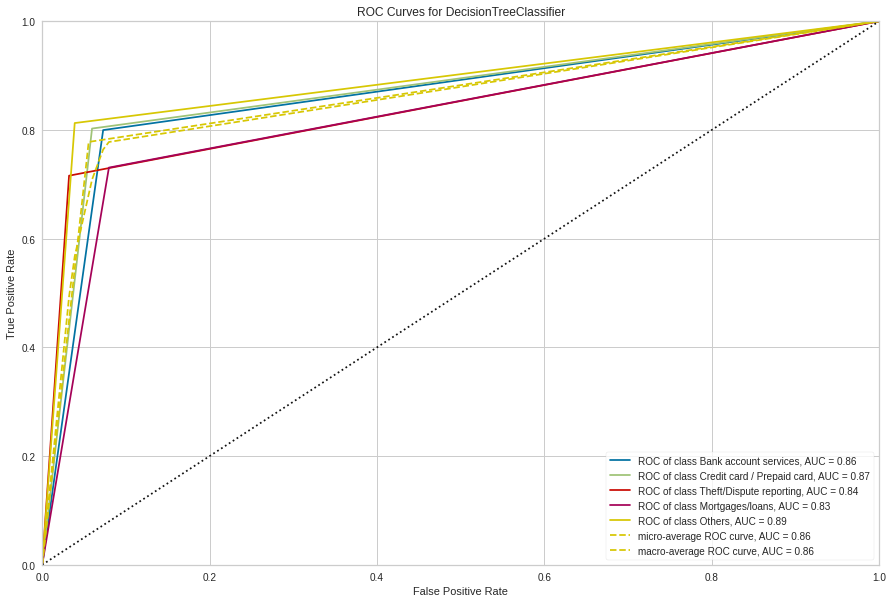

In [91]:
#visualizing the ROCAUC curve and the score for all the 5 class labels

fig = plt.figure(figsize=(15,10))

visualizer = ROCAUC(dt, encoder={0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Theft/Dispute reporting", 3:"Mortgages/loans", 4:"Others"})

visualizer.fit(X_train,y_train)
visualizer.score(X_test, y_test) 
visualizer.show()

* **Model 3. Random Forest Classifier**

In [92]:
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [93]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [94]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [95]:
# Getting the score of the base model
rf.score(X_test, y_test)

0.8227031131359149

* With the base Random Forest model, we get an accuracy of 82.27%

* **HyperParameter Tuning**

In [96]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [97]:
# Setup random hyperparameter search for Random Forest Classfier
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [98]:
# Check the best parameters
rf_hpt.best_params_ 

{'n_estimators': 810,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_depth': 10}

In [99]:
# Evaluating the tuned Random forest classifer model
rf_hpt.score(X_test, y_test)

0.7433561123766135

* After Randomized Search, Random Forecast model accuracy is only 74.10%. We will fine tune the results further based on Grid Search

In [100]:
rf_grid = {"n_estimators": [200, 260, 300],
           "max_depth": [7, 10, 15],
           "min_samples_split": [10, 12, 14],
           "min_samples_leaf": [6, 8, 10]}

In [101]:
# Setup grid hyperparameter search for Random Forest Classifier
rf_hpt = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [102]:
# Check the RF best parameters
rf_hpt.best_params_

{'max_depth': 15,
 'min_samples_leaf': 6,
 'min_samples_split': 14,
 'n_estimators': 200}

In [103]:
# Evaluating the tuned RF model
rf_hpt.score(X_test, y_test)

0.7501898253606681

* After Grid Search, the Random Forest model has an accuracy of 75.01%.

In [104]:
# Save Random Forest Model
pickle.dump(rf_hpt, open("rf_model.pk1", "wb"))

* **Model Evaluation**

In [105]:
# Load pickled model
rf_model = pickle.load(open("rf_model.pk1", "rb"))

In [106]:
# Make predictions on test data
y_pred = rf_model.predict(X_test)

In [107]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1183   88    1   32    9]
 [  68 1097    0  100    6]
 [ 124  180   49  101  109]
 [ 160  130    0  907    6]
 [  66  115    0   21  716]]


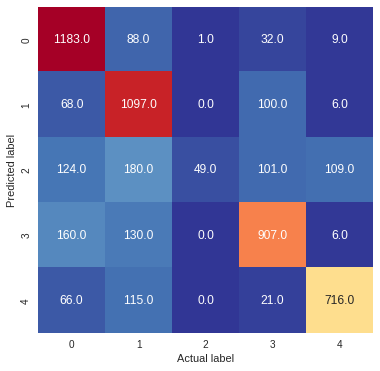

In [108]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="RdYlBu_r", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [109]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Theft/Dispute reporting", "Mortgages/loans", "Others"]

In [110]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.74      0.90      0.81      1313
Credit card / Prepaid card       0.68      0.86      0.76      1271
   Theft/Dispute reporting       0.98      0.09      0.16       563
           Mortgages/loans       0.78      0.75      0.77      1203
                    Others       0.85      0.78      0.81       918

                  accuracy                           0.75      5268
                 macro avg       0.81      0.68      0.66      5268
              weighted avg       0.78      0.75      0.72      5268



* The overall accuracy of the Random Forest model is 75%
* Precision and Accuracy are 78% and 75% respectively and we can see that the model overfits for "Others" category for Precision
* This is a very poor model as compared to Logistic Regression where the accuracy was 92%

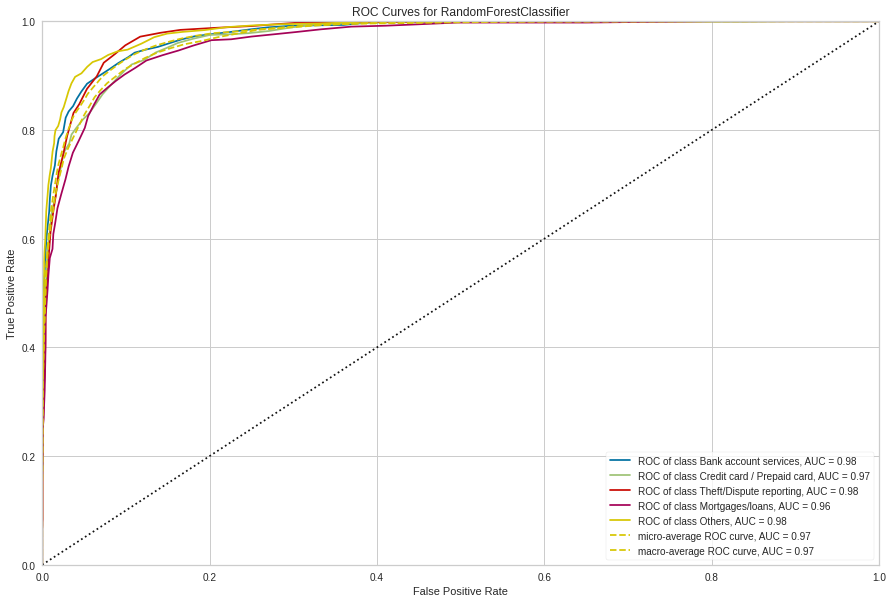

In [111]:
#visualizing the ROCAUC curve and the score for all the 5 class labels

fig = plt.figure(figsize=(15,10))

visualizer = ROCAUC(rf, encoder={0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Theft/Dispute reporting", 3:"Mortgages/loans", 4:"Others"})

visualizer.fit(X_train,y_train)
visualizer.score(X_test, y_test) 
visualizer.show()

* **Model 4. Naive Bayes**

In [112]:
from sklearn.naive_bayes import MultinomialNB
#Initialize Multinomial Naive Bayes model
clf = MultinomialNB()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report

clf_report = classification_report(y_test,y_pred)

print(clf_report)

              precision    recall  f1-score   support

           0       0.65      0.92      0.76      1313
           1       0.72      0.75      0.74      1271
           2       0.90      0.02      0.03       563
           3       0.74      0.77      0.76      1203
           4       0.85      0.76      0.80       918

    accuracy                           0.72      5268
   macro avg       0.77      0.64      0.62      5268
weighted avg       0.75      0.72      0.68      5268



* The overall accuracy of the Naive Bayes model is 72%
* Precision and Accuracy are 75% and 72% respectively and we can see that the model overfits for "Others" category for Precision
* This is also very poor model as compared to Logistic Regression where the accuracy was 92%

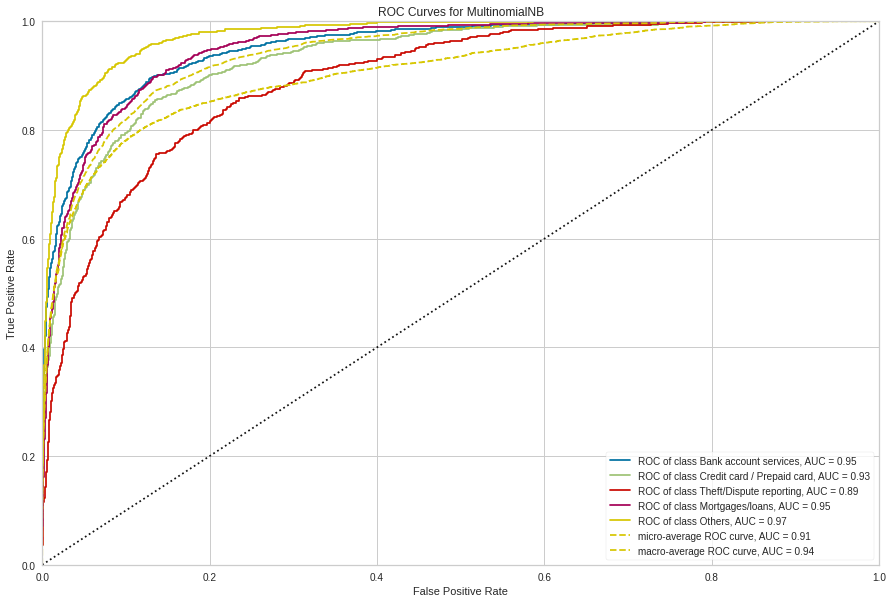

In [113]:
#visualizing the ROCAUC curve and the score for all the 5 class labels

fig = plt.figure(figsize=(15,10))

visualizer = ROCAUC(clf, encoder={0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Theft/Dispute reporting", 3:"Mortgages/loans", 4:"Others"})

visualizer.fit(X_train,y_train)
visualizer.score(X_test, y_test) 
visualizer.show()

###Model Inference

In [114]:
# Few sample complaints to infer the model

df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [115]:
#Function to predict the Logistic Regression
def predict_lr(text):
    Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others", 3:"Theft/Dispute reporting", 4:"Mortgages/loans" }
    X_new_counts = vect_count.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = logisticreg.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [116]:
df_complaints['predicted _dept'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,predicted _dept
0,I can not get from chase who services my mortg...,Mortgages/loans
1,The bill amount of my credit card was debited ...,Credit card / Prepaid card
2,I want to open a salary account at your downto...,Bank account services
3,"Yesterday, I received a fraudulent email regar...",Theft/Dispute reporting
4,What is the procedure to know my CIBIL score?,Credit card / Prepaid card
5,I need to know the number of bank branches and...,Bank account services


**Observed that the Logistic Regression Model predicts the Departments to which the complaints belong to.**

### Consolidated Results
We experimented with 4 models - Logistic Regression, Decision Tree Classifier, Random Forest Classifier and Naive Bayes to predict any new complaints to the relevant Topics. Following are the results

#### **Results**

#### 1. Logistic Regression
* The overall accuracy of the Logistic Regression model is 92%.
* Precision and Recall are 92% and 92% respectively which makes this is a very good model.

#### 2. Decision Tree
* The overall accuracy of the Decision Tree model is 77%
* Precision and Recall are 78% and 77% respectively

### 3. Random Forest
* The overall accuracy of the Random Forest model is 75%
* Precision and Recall are 78% and 75% respectively and we can see that the model overfits for "Others" category for Precision

### 4. Naive Bayes
* The overall accuracy of the Naive Bayes model is 72%
* Precision and Recall are 75% and 72% respectively and we can see that the model overfits for "Others" category for Precision

### **Conclusion**
Based on the above 4 models results, Logistic Regression is the best model with an accuracy of 92% with Precision and Recall as 92% and 92% respectively.

 **Hence proved that Logistic Regression is a good fit for this case study**